# Importação dos Dados de Treinamento

Este conjunto de dados foi gerado pelo script trusted_dataset, dividindo em dados para treinar o modelo e para validação.

In [2]:
import pandas as pd

data_url = "https://raw.githubusercontent.com/cristiano-deepdb/Churn_Customers/main/data/trusted/dataset_train.parquet"

customer_data = pd.read_parquet(data_url)

print("Dataset baixado e carregado com sucesso!")

Dataset baixado e carregado com sucesso!


In [3]:
customer_data.head()

,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins,cost_pressure_index,usage_intensity,support_frequency,roaming_dependency,Churn
index,,,,,,,,,,,,,,,
3286,106,1,1,3.54,0,220.1,105,92.4,11.11,13.1,0.120238,2.076415,0.000000,0.059518,0
86,94,1,0,0.00,4,157.9,105,41.0,7.75,8.0,0.189024,1.489623,0.042105,0.050665,1
1349,71,1,1,1.51,2,141.4,107,53.1,8.15,5.6,0.153484,1.309259,0.027778,0.039604,0
1649,130,1,0,0.00,0,68.4,86,29.0,9.67,10.4,0.333448,0.786207,0.000000,0.152047,0
3000,87,1,0,0.42,3,223.2,109,53.2,6.38,14.5,0.119925,2.029091,0.034091,0.064964,0


# 4. Construção do Modelo

## Divisão em Treino e Validação

Utilizamos uma divisão estratificada para manter as proporções das classes em ambos os conjuntos, prevenindo vieses devido a desequilíbrios.

In [4]:
from sklearn.model_selection import train_test_split

features = customer_data.drop(columns=['Churn'])
target = customer_data['Churn']

train_features, val_features, train_target, val_target = train_test_split(
    features, target,
    test_size=0.2,
    stratify=target,
    random_state=42
)

## Modelo de Regressão Logística

Um modelo básico de referência. Utiliza a função logística para gerar probabilidades bem calibradas.

In [ ]:
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(train_features, train_target)

In [6]:
from sklearn.metrics import classification_report, roc_auc_score

logistic_predictions = logistic_model.predict(val_features)
logistic_probabilities = logistic_model.predict_proba(val_features)[:,1]

print(classification_report(val_target, logistic_predictions))
print("ROC AUC:", roc_auc_score(val_target, logistic_probabilities))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92       457
           1       0.55      0.16      0.24        77

    accuracy                           0.86       534
   macro avg       0.71      0.57      0.58       534
weighted avg       0.83      0.86      0.82       534

ROC AUC: 0.8130381653357583


## Floresta Aleatória

Um modelo ensemble de árvores de decisão que identifica relações não lineares e interações entre features, frequentemente superior em datasets complexos.

In [7]:
from sklearn.ensemble import RandomForestClassifier

forest_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    class_weight='balanced',
    random_state=42
)

forest_model.fit(train_features, train_target)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",12
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

In [8]:
from sklearn.metrics import classification_report, roc_auc_score

forest_predictions = forest_model.predict(val_features)
forest_probabilities = forest_model.predict_proba(val_features)[:,1]

print(classification_report(val_target, forest_predictions))
print("ROC AUC:", roc_auc_score(val_target, forest_probabilities))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       457
           1       0.86      0.62      0.72        77

    accuracy                           0.93       534
   macro avg       0.90      0.80      0.84       534
weighted avg       0.93      0.93      0.93       534

ROC AUC: 0.9296371025036233


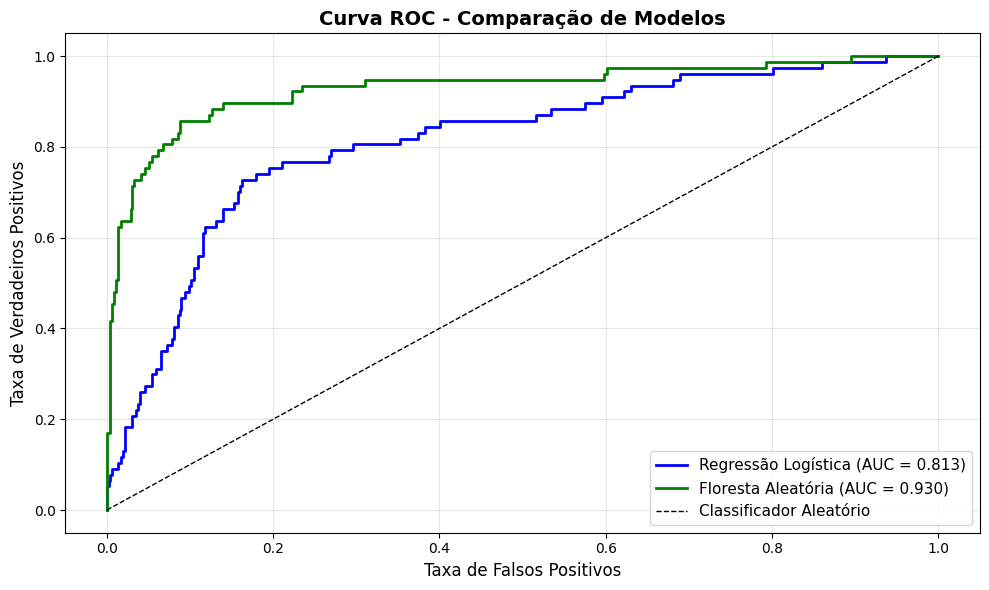

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calcular curva ROC para ambos os modelos
logistic_fpr, logistic_tpr, _ = roc_curve(val_target, logistic_probabilities)
forest_fpr, forest_tpr, _ = roc_curve(val_target, forest_probabilities)

logistic_auc = auc(logistic_fpr, logistic_tpr)
forest_auc = auc(forest_fpr, forest_tpr)

# Plotar
plt.figure(figsize=(10, 6))
plt.plot(logistic_fpr, logistic_tpr, label=f'Regressão Logística (AUC = {logistic_auc:.3f})', linewidth=2, color='blue')
plt.plot(forest_fpr, forest_tpr, label=f'Floresta Aleatória (AUC = {forest_auc:.3f})', linewidth=2, color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Classificador Aleatório', linewidth=1)

plt.xlabel('Taxa de Falsos Positivos', fontsize=12)
plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=12)
plt.title('Curva ROC - Comparação de Modelos', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

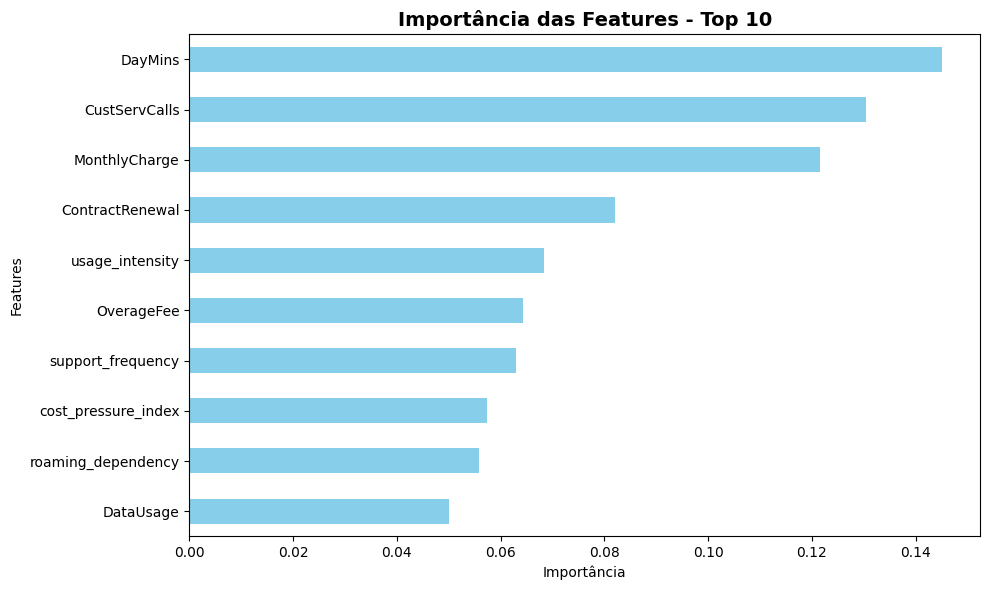

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

feature_importance = pd.Series(forest_model.feature_importances_, index=features.columns)
top_features = feature_importance.sort_values(ascending=False).head(10)

# Plotar importância das features
plt.figure(figsize=(10, 6))
top_features.plot(kind='barh', color='skyblue')
plt.title('Importância das Features - Top 10', fontsize=14, fontweight='bold')
plt.xlabel('Importância')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 5. Validação dos Modelos

Aqui, testamos os modelos com um conjunto de dados independente. O foco é verificar a capacidade de generalização e identificar eventuais sobreajustes.

In [ ]:
import pandas as pd

test_data_url = "https://raw.githubusercontent.com/cristiano-deepdb/Churn_Customers/main/data/trusted/dataset_test.parquet"

test_data = pd.read_parquet(test_data_url)

print("Dataset baixado e carregado com sucesso!")

Dataset baixado e carregado com sucesso!


In [ ]:
# Preparar test_features e test_target a partir do dataset de teste
test_features = test_data.drop(columns=['Churn'])
test_target = test_data['Churn']

print(f"test_features shape: {test_features.shape}")
print(f"test_target shape: {test_target.shape}")

test_features shape: (667, 14)
test_target shape: (667,)


In [ ]:
# Avaliar Regressão Logística no dataset de teste
logistic_test_predictions = logistic_model.predict(test_features)
logistic_test_probabilities = logistic_model.predict_proba(test_features)[:,1]

print("=" * 60)
print("REGRESSÃO LOGÍSTICA - DATASET DE TESTE")
print("=" * 60)
print(classification_report(test_target, logistic_test_predictions))
print("ROC AUC:", roc_auc_score(test_target, logistic_test_probabilities))

# Avaliar Floresta Aleatória no dataset de teste
forest_test_predictions = forest_model.predict(test_features)
forest_test_probabilities = forest_model.predict_proba(test_features)[:,1]

print("\n" + "=" * 60)
print("FLORESTA ALEATÓRIA - DATASET DE TESTE")
print("=" * 60)
print(classification_report(test_target, forest_test_predictions))
print("ROC AUC:", roc_auc_score(test_target, forest_test_probabilities))

REGRESSÃO LOGÍSTICA - DATASET DE TESTE
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       570
           1       0.49      0.19      0.27        97

    accuracy                           0.85       667
   macro avg       0.68      0.58      0.59       667
weighted avg       0.82      0.85      0.82       667

ROC AUC: 0.8058238379453789

FLORESTA ALEATÓRIA - DATASET DE TESTE
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       570
           1       0.77      0.59      0.67        97

    accuracy                           0.91       667
   macro avg       0.85      0.78      0.81       667
weighted avg       0.91      0.91      0.91       667

ROC AUC: 0.8691264243081932


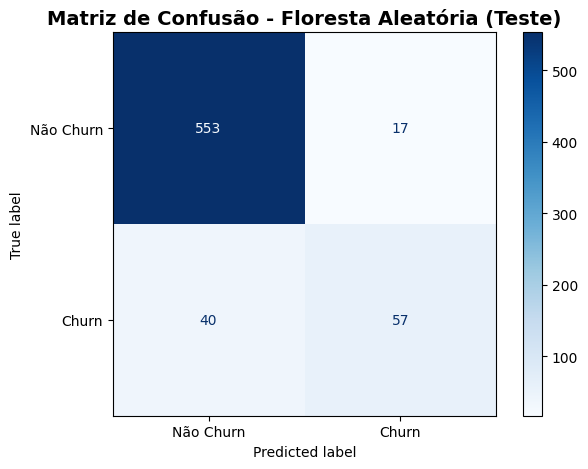

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Matriz de confusão para Floresta Aleatória no teste
cm = confusion_matrix(test_target, forest_test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não Churn', 'Churn'])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusão - Floresta Aleatória (Teste)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Calcular métricas no dataset de treino (validação)
train_metrics = {
    'Regressão Logística': {
        'Acurácia': accuracy_score(val_target, logistic_predictions),
        'Precisão': precision_score(val_target, logistic_predictions),
        'Revocação': recall_score(val_target, logistic_predictions),
        'F1-Score': f1_score(val_target, logistic_predictions),
        'ROC AUC': roc_auc_score(val_target, logistic_probabilities)
    },
    'Floresta Aleatória': {
        'Acurácia': accuracy_score(val_target, forest_predictions),
        'Precisão': precision_score(val_target, forest_predictions),
        'Revocação': recall_score(val_target, forest_predictions),
        'F1-Score': f1_score(val_target, forest_predictions),
        'ROC AUC': roc_auc_score(val_target, forest_probabilities)
    }
}

# Calcular métricas no dataset de teste
test_metrics = {
    'Regressão Logística': {
        'Acurácia': accuracy_score(test_target, logistic_test_predictions),
        'Precisão': precision_score(test_target, logistic_test_predictions),
        'Revocação': recall_score(test_target, logistic_test_predictions),
        'F1-Score': f1_score(test_target, logistic_test_predictions),
        'ROC AUC': roc_auc_score(test_target, logistic_test_probabilities)
    },
    'Floresta Aleatória': {
        'Acurácia': accuracy_score(test_target, forest_test_predictions),
        'Precisão': precision_score(test_target, forest_test_predictions),
        'Revocação': recall_score(test_target, forest_test_predictions),
        'F1-Score': f1_score(test_target, forest_test_predictions),
        'ROC AUC': roc_auc_score(test_target, forest_test_probabilities)
    }
}

# Criar DataFrames para comparação
train_metrics_df = pd.DataFrame(train_metrics).T
test_metrics_df = pd.DataFrame(test_metrics).T

print("📊 MÉTRICAS - DATASET DE TREINO (VALIDAÇÃO)")
print("=" * 80)
print(train_metrics_df.round(4))

print("\n📊 MÉTRICAS - DATASET DE TESTE")
print("=" * 80)
print(test_metrics_df.round(4))

print("\n📈 DIFERENÇA (Teste - Treino)")
print("=" * 80)
print((test_metrics_df - train_metrics_df).round(4))

📊 MÉTRICAS - DATASET DE TREINO (VALIDAÇÃO)
                     Acurácia  Precisão  Revocação  F1-Score  ROC AUC
Regressão Logística    0.8596    0.5455     0.1558    0.2424   0.8130
Floresta Aleatória     0.9307    0.8571     0.6234    0.7218   0.9296

📊 MÉTRICAS - DATASET DE TESTE
                     Acurácia  Precisão  Revocação  F1-Score  ROC AUC
Regressão Logística    0.8531    0.4865     0.1856    0.2687   0.8058
Floresta Aleatória     0.9145    0.7703     0.5876    0.6667   0.8691

📈 DIFERENÇA (Teste - Treino)
                     Acurácia  Precisão  Revocação  F1-Score  ROC AUC
Regressão Logística   -0.0065   -0.0590     0.0297    0.0262  -0.0072
Floresta Aleatória    -0.0162   -0.0869    -0.0357   -0.0551  -0.0605


# 6. Aplicação Prática

Mostramos o uso do modelo em ambiente produtivo. Calculamos scores de churn por cliente e definimos categorias de risco para estratégias de retenção direcionadas.

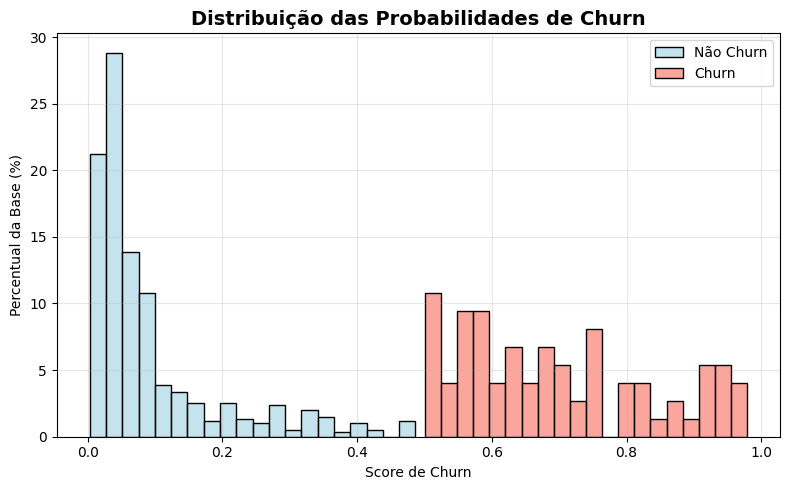

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Preparar dados tratados para predição
treated_test_data = test_features.copy()

# Fazer predições com o melhor modelo (Floresta Aleatória)
churn_probabilities = forest_model.predict_proba(treated_test_data)[:,1]

# Separar probabilidades por classe
non_churn_probabilities = forest_model.predict_proba(treated_test_data[forest_model.predict(treated_test_data)==0])[:,1]
positive_churn_probabilities = forest_model.predict_proba(treated_test_data[forest_model.predict(treated_test_data)==1])[:,1]

# Plotar distribuição de probabilidade
plt.figure(figsize=(8, 5))
sns.histplot(non_churn_probabilities, bins=20, stat='percent', color='lightblue', label='Não Churn', alpha=0.7)
sns.histplot(positive_churn_probabilities, bins=20, stat='percent', color='salmon', label='Churn', alpha=0.7)
plt.title('Distribuição das Probabilidades de Churn', fontsize=14, fontweight='bold')
plt.xlabel('Score de Churn')
plt.ylabel('Percentual da Base (%)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Regra de uso do Score
all_probabilities = forest_model.predict_proba(treated_test_data)

# Classificar cada cliente
risk_categories = []

for churn_probability in all_probabilities[:, 1]:
    if churn_probability >= 0.9:
        risk_categories.append('Alto risco de churn')
    elif churn_probability > 0.75:
        risk_categories.append('Médio risco de churn')
    else:
        risk_categories.append('Baixo risco de churn')

# Criar DataFrame com resultados
results_df = pd.DataFrame({
    'Probabilidade_Churn': all_probabilities[:, 1],
    'Classificacao_Risco': risk_categories
})

# Exibir distribuição de riscos
print("=" * 60)
print("DISTRIBUIÇÃO DE RISCO DE CHURN")
print("=" * 60)
print(results_df['Classificacao_Risco'].value_counts())
print("\n" + "=" * 60)
print("ESTATÍSTICAS DE PROBABILIDADE POR RISCO")
print("=" * 60)
print(results_df.groupby('Classificacao_Risco')['Probabilidade_Churn'].describe())

DISTRIBUIÇÃO DE RISCO DE CHURN
Classificacao_Risco
Baixo risco de churn    641
Médio risco de churn     15
Alto risco de churn      11
Name: count, dtype: int64

ESTATÍSTICAS DE PROBABILIDADE POR RISCO
                      count      mean       std       min       25%       50%  \
Classificacao_Risco                                                             
Alto risco de churn    11.0  0.938642  0.020227  0.912996  0.926948  0.934620   
Baixo risco de churn  641.0  0.130356  0.167424  0.003255  0.030521  0.056447   
Médio risco de churn   15.0  0.808452  0.046706  0.750315  0.759321  0.808005   

                           75%       max  
Classificacao_Risco                       
Alto risco de churn   0.951075  0.978852  
Baixo risco de churn  0.141471  0.747120  
Médio risco de churn  0.835186  0.883917  


In [ ]:
# import os
# import pickle

# # Definir diretório para armazenar os modelos treinados
# saved_models_path = '../models'
# if not os.path.exists(saved_models_path):
#     os.makedirs(saved_models_path)

# # Persistir o modelo de Floresta Aleatória
# rf_file = os.path.join(saved_models_path, 'rf_churn_model.pkl')
# with open(rf_file, 'wb') as file:
#     pickle.dump(forest_model, file)
# print(f"Modelo de Floresta Aleatória armazenado em: {rf_file}")

# print("\nModelos salvos com sucesso para uso futuro!")
# print(f"Diretório de armazenamento: {os.path.abspath(saved_models_path)}")